In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon, LineString
import numpy as np
from sklearn.cluster import KMeans
from shapely.ops import voronoi_diagram, unary_union
from shapely.plotting import plot_polygon, plot_line
from shapely.geometry import shape
from shapely import from_geojson, get_parts

from utils import *

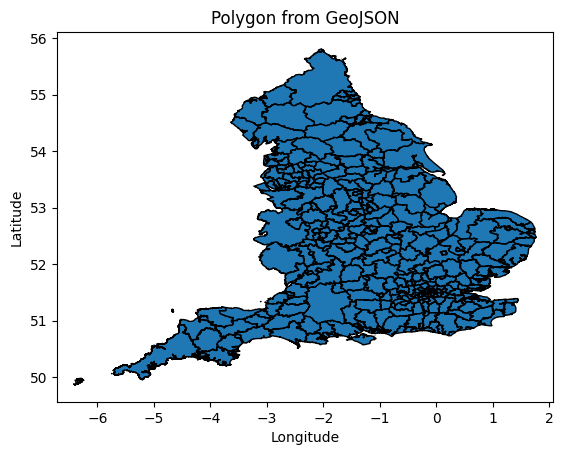

In [2]:
# Read NI GEOJSON file to a GeoPandas Dataframe, plot using matplotlib

geojson_file = './UK-GeoJSON/json/administrative/eng/lad.json'
gdf = gpd.read_file(geojson_file)
gdf.plot(edgecolor='black')  # You can customize the colors and styles
plt.title('Polygon from GeoJSON')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')  # Keep aspect ratio
plt.show()

In [3]:
# Convert from raw geojson to shapely polygon with no islands or internal borders

# Extract Shapely objects from GDF to shapes array
polygons = []
for i in range(gdf.shape[0]):
    polygons.append(gdf.iloc[i]['geometry'])
# plot_map(polygons)

# Remove Islands
no_islands = remove_islands(polygons)
# plot_map(no_islands)

# Remove internal borders
unified_areas = unary_union(no_islands)
unified_ext_coords = unified_areas.exterior.coords
border_polygon = Polygon(unified_ext_coords)
plot_map(border_polygon)

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

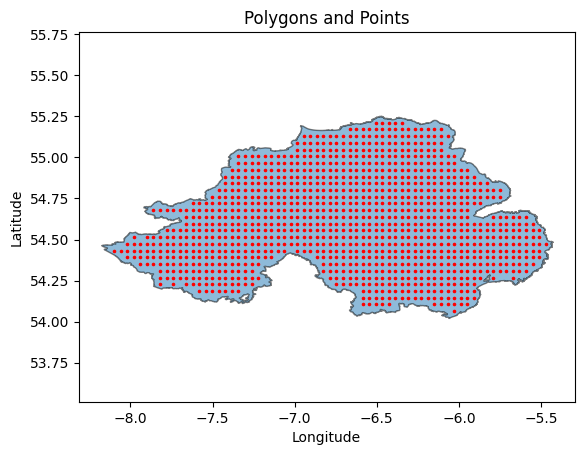

In [ ]:
# Generate points across the polygon
min_x, min_y, max_x, max_y = border_polygon.bounds
point_map = generate_points_no_outline(min_x, max_x, min_y, max_y, border_polygon)

plot_points_and_map(point_map, border_polygon, 10)

In [ ]:
def kmeans_cluster(input_points, n_clusters):
    

    # convert each point to plain coords
    unclustered_points = [[point.x, point.y] for point in input_points]
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(unclustered_points)

    labels = kmeans.labels_

    # lists to store points for each cluster
    cluster_points = [[] for _ in range(n_clusters)]

    # separate points into clusters based on labels
    for point_idx, label in enumerate(labels):
        cluster_points[label].append(unclustered_points[point_idx])
    
    return cluster_points

# def balanced_kmeans_cluster(input_points, n_clusters):

#     unclustered_points = [[point.x, point.y] for point in input_points]
#     unclustered_tensor = torch.tensor(unclustered_points, dtype=torch.float32)

#     print(unclustered_tensor.shape)
    
#     N = len(unclustered_points)
#     cluster_size = N//n_clusters
    
#     choices, centers = kmeans_equal(unclustered_tensor, num_clusters=n_clusters, cluster_size=cluster_size)

#     print(choices)
#     print(centers)

# balanced_kmeans_cluster(generated_points, 30)


cluster_points = kmeans_cluster(point_map, 30)

# print number of points in each cluster
for i, points in enumerate(cluster_points):
    print(f"Cluster {i+1} has {len(points)} points.")

Cluster 1 has 42 points.
Cluster 2 has 40 points.
Cluster 3 has 35 points.
Cluster 4 has 37 points.
Cluster 5 has 37 points.
Cluster 6 has 40 points.
Cluster 7 has 37 points.
Cluster 8 has 39 points.
Cluster 9 has 39 points.
Cluster 10 has 33 points.
Cluster 11 has 40 points.
Cluster 12 has 35 points.
Cluster 13 has 42 points.
Cluster 14 has 32 points.
Cluster 15 has 35 points.
Cluster 16 has 32 points.
Cluster 17 has 38 points.
Cluster 18 has 31 points.
Cluster 19 has 41 points.
Cluster 20 has 36 points.
Cluster 21 has 42 points.
Cluster 22 has 36 points.
Cluster 23 has 27 points.
Cluster 24 has 43 points.
Cluster 25 has 31 points.
Cluster 26 has 43 points.
Cluster 27 has 36 points.
Cluster 28 has 31 points.
Cluster 29 has 35 points.
Cluster 30 has 35 points.


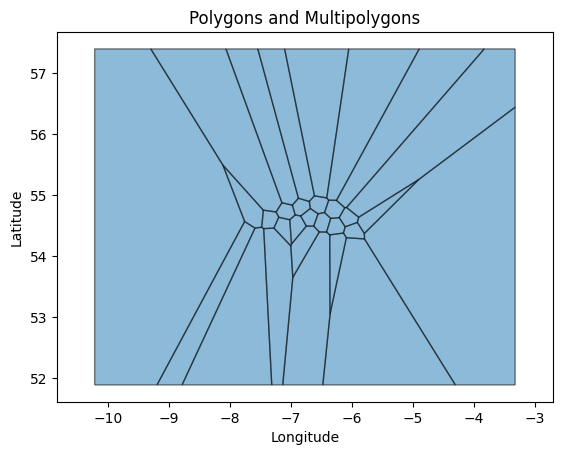

In [ ]:
# get convex hulls of each cluster 
# convex hull is the smallest convex polygon that encloses all points
convex_hulls = [MultiPoint(x).convex_hull for x in cluster_points]

# get centroids of convex hulls
# list of shapely points showing vertices of convex hulls
convex_hulls_centroids = [x.centroid for x in convex_hulls]

# Voronoi diagram of centroids
voronoi_diagram = voronoi_diagram(MultiPoint([centroid for centroid in convex_hulls_centroids]))
voronoi_polygons = voronoi_polygons = list(voronoi_diagram.geoms)

final = [border_polygon] + voronoi_polygons
plot_map(voronoi_polygons)

# # Align voronoi polygons with main polygon
# aligned_polygon = MultiPolygon([x.buffer(0).intersection(polygon) for x in voronoi_polygons])

# print(aligned_polygon)

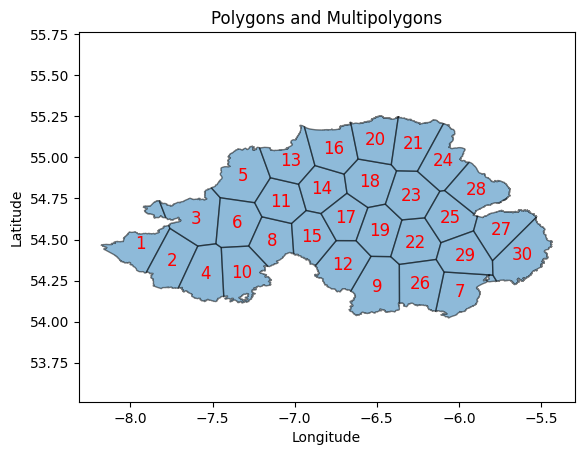

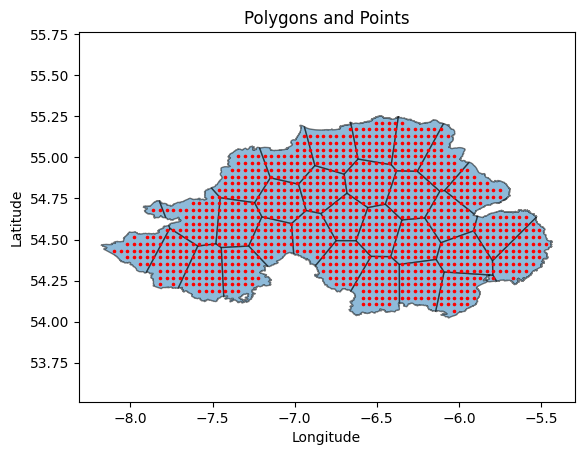

In [ ]:
intersection = [x.buffer(0).intersection(border_polygon) for x in voronoi_polygons]
plot_map_with_labels(intersection)
plot_points_and_map(point_map, intersection, 10)
# aligned_polygon = MultiPolygon([x.buffer(0).intersection(polygon) for x in voronoi_polygons])

In [ ]:
# Save the constituency set
gdf = gpd.GeoDataFrame(geometry=intersection)
gdf.to_file("./generated_constituencies/eng_test.geojson", driver="GeoJSON")

/cs/home/jje4/Documents/CS4099/venv/lib64/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Text(0.5, 1.0, 'Scatter Plot of Points vs. Area')

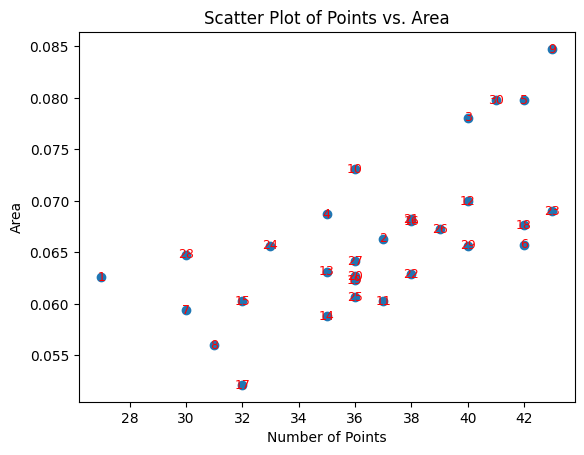

In [ ]:
# plot number of points contained vs area


# print number of points in each cluster
num_points = []
areas = []

for polygon in intersection:
    count = 0
    for point in point_map:
        if polygon.contains(point):
            count += 1
    num_points.append(count)
    areas.append(polygon.area)

plt.scatter(num_points, areas)

# Label each point in the scatter plot
for idx, (num, area) in enumerate(zip(num_points, areas)):
    plt.text(num, area, str(idx + 1), fontsize=9, ha='center', va='center', color='red')

# Optional: Add labels for axes and title
plt.xlabel('Number of Points')
plt.ylabel('Area')
plt.title('Scatter Plot of Points vs. Area')


# plt.scatter()

[0.06257122777102357, 0.06634170645202904, 0.07806977009511196, 0.06869388536920262, 0.0797492364812471, 0.06574372262912896, 0.059373369887911094, 0.05596650723749936, 0.08474982377154805, 0.0731070974481641, 0.06024117615730078, 0.06996614353419048, 0.06311745359430769, 0.05878651713029819, 0.06024844572098635, 0.06805801362498261, 0.052127047540084126, 0.06763204438461654, 0.062278016014142776, 0.0626941262716485, 0.06820025852980449, 0.06285685968373778, 0.0689953355688799, 0.0656400701158157, 0.06061850660875116, 0.06724308946909613, 0.06414214489037934, 0.06476575894670249, 0.0656500768807834, 0.07978293060278137]
Variance of areas =5.222719188042003e-05


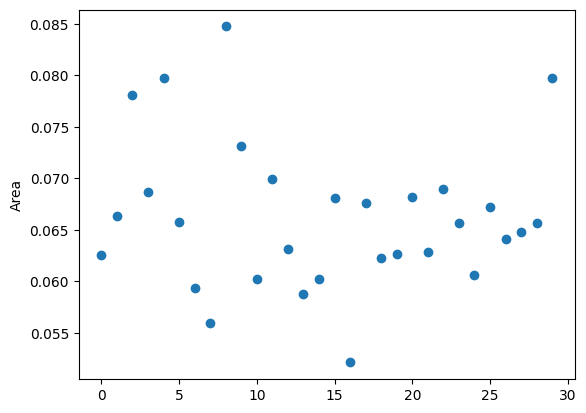

In [ ]:
areas = []
for p in intersection:
    areas.append(p.area)
print(areas)
variance = np.var(areas, ddof=1)
print("Variance of areas ="+ str(variance))
plt.scatter(range(len(areas)), areas)
plt.ylabel('Area')
# plt.ylim(0.03, 0.07)
plt.show()

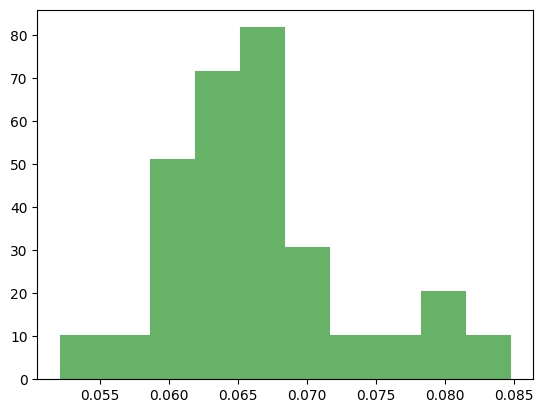

In [ ]:
plt.hist(areas, bins=10, density=True, alpha=0.6, color='g')
plt.show()